In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
df_autism = pd.read_csv(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Portfolio Projects_storage\Day 30 - Autism Prediction\train.csv')
df = df_autism.copy()

In [3]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [5]:
df.shape

(800, 22)

In [6]:
obj_type = list(df.select_dtypes(include = 'object').columns)

for obj in obj_type:
    display(df[obj].value_counts())


# Gender, Jaundice, Autism convert to 0,1 
# Check ? for ethnicity to country_of_res to see [check]
# drop 18 and more, relation, used_app, ID before column 



gender
m    530
f    270
Name: count, dtype: int64

ethnicity
White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               3
Name: count, dtype: int64

jaundice
no     615
yes    185
Name: count, dtype: int64

austim
no     669
yes    131
Name: count, dtype: int64

contry_of_res
United States           134
India                   108
New Zealand              78
United Kingdom           67
Jordan                   55
United Arab Emirates     40
Australia                37
Canada                   30
Afghanistan              22
Netherlands              20
Austria                  18
Sri Lanka                17
Brazil                   12
France                   10
Spain                    10
Kazakhstan               10
Ireland                   9
Iran                      8
Russia                    7
South Africa              6
Bahamas                   6
Italy                     6
Malaysia                  6
Viet Nam                  5
Nicaragua                 4
Pakistan                  4
Armenia                   4
AmericanSamoa             4
Iraq                      4
Azerbaijan                4
Aruba                     4
Saudi Arabia              4
China                     4
Mexico                    4
Ukraine                   3
Niger 

used_app_before
no     750
yes     50
Name: count, dtype: int64

age_desc
18 and more    800
Name: count, dtype: int64

relation
Self                        709
?                            40
Parent                       29
Relative                     18
Others                        2
Health care professional      2
Name: count, dtype: int64

In [7]:
df = df.drop(columns = ['used_app_before', 'relation', 'age_desc'])
df.columns

Index(['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
       'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age',
       'gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'result',
       'Class/ASD'],
      dtype='object')

In [8]:
# fill ? with the existing data [mode was used to identify what to impute]

country_ethnicity = df.loc[df['ethnicity'] != '?', ['contry_of_res', 'ethnicity']]
map_country_ethnicity = country_ethnicity.groupby('contry_of_res')['ethnicity'].apply(
    lambda x: x.value_counts().index[0] if len(x)>0 else 'Unknown'
).to_dict()

missing_ethnicity = ((df['ethnicity'] == '?') | df['ethnicity'].isna())
df.loc[missing_ethnicity, 'ethnicity'] = df.loc[missing_ethnicity, 'contry_of_res'].map(map_country_ethnicity)

df['ethnicity'] = df['ethnicity'].replace('others', 'Others')



In [9]:
# fill 0, 1 per yes and no, m and f 

yes_no_cols = ['jaundice', 'austim']

for col in yes_no_cols:
    df[col] = df[col].apply(lambda x: 1 if x == 'yes' else 0 )

df['gender'] = df['gender'].apply(lambda x: 1 if x == 'm' else 0)

In [10]:
cols_for_le = ['contry_of_res', 'ethnicity']

for col in cols_for_le:
    encoder = LabelEncoder()
    df[col + '_encoded'] = encoder.fit_transform(df[col])

In [11]:
df[['contry_of_res','contry_of_res_encoded']].drop_duplicates().sort_values('contry_of_res_encoded')


,contry_of_res,contry_of_res_encoded
60,Afghanistan,0
72,AmericanSamoa,1
223,Angola,2
269,Argentina,3
140,Armenia,4
98,Aruba,5
15,Australia,6
0,Austria,7
127,Azerbaijan,8
78,Bahamas,9


In [12]:
df[['ethnicity','ethnicity_encoded']].drop_duplicates().sort_values('ethnicity_encoded')

,ethnicity,ethnicity_encoded
17,Asian,0
7,Black,1
16,Hispanic,2
92,Latino,3
0,Middle Eastern,4
9,Others,5
6,Pasifika,6
77,South Asian,7
38,Turkish,8
2,White-European,9


In [13]:
df.loc[df['ID'] == 224, 'ethnicity'] = df.loc[df['ID'] == 224, 'ethnicity'].fillna('Others')

In [14]:
df.loc[df['contry_of_res'] == 'Angola', ['contry_of_res','ethnicity']]

,contry_of_res,ethnicity
223,Angola,Others


In [15]:
df.describe()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,austim,result,Class/ASD,contry_of_res_encoded,ethnicity_encoded
count,800.0000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,28.452118,0.662500,0.231250,0.16375,8.537303,0.201250,34.062500,5.952500
std,231.0844,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.310966,0.473153,0.421896,0.37028,4.807676,0.401185,16.767305,3.267811
min,1.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.718550,0.000000,0.000000,0.00000,-6.137748,0.000000,0.000000,0.000000
25%,200.7500,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.198153,0.000000,0.000000,0.00000,5.306575,0.000000,25.000000,4.000000
50%,400.5000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.848350,1.000000,0.000000,0.00000,9.605299,0.000000,35.000000,7.000000
75%,600.2500,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.865429,1.000000,0.000000,0.00000,12.514484,0.000000,53.000000,9.000000
max,800.0000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.461718,1.000000,1.000000,1.00000,15.853126,1.000000,55.000000,10.000000


<Axes: >

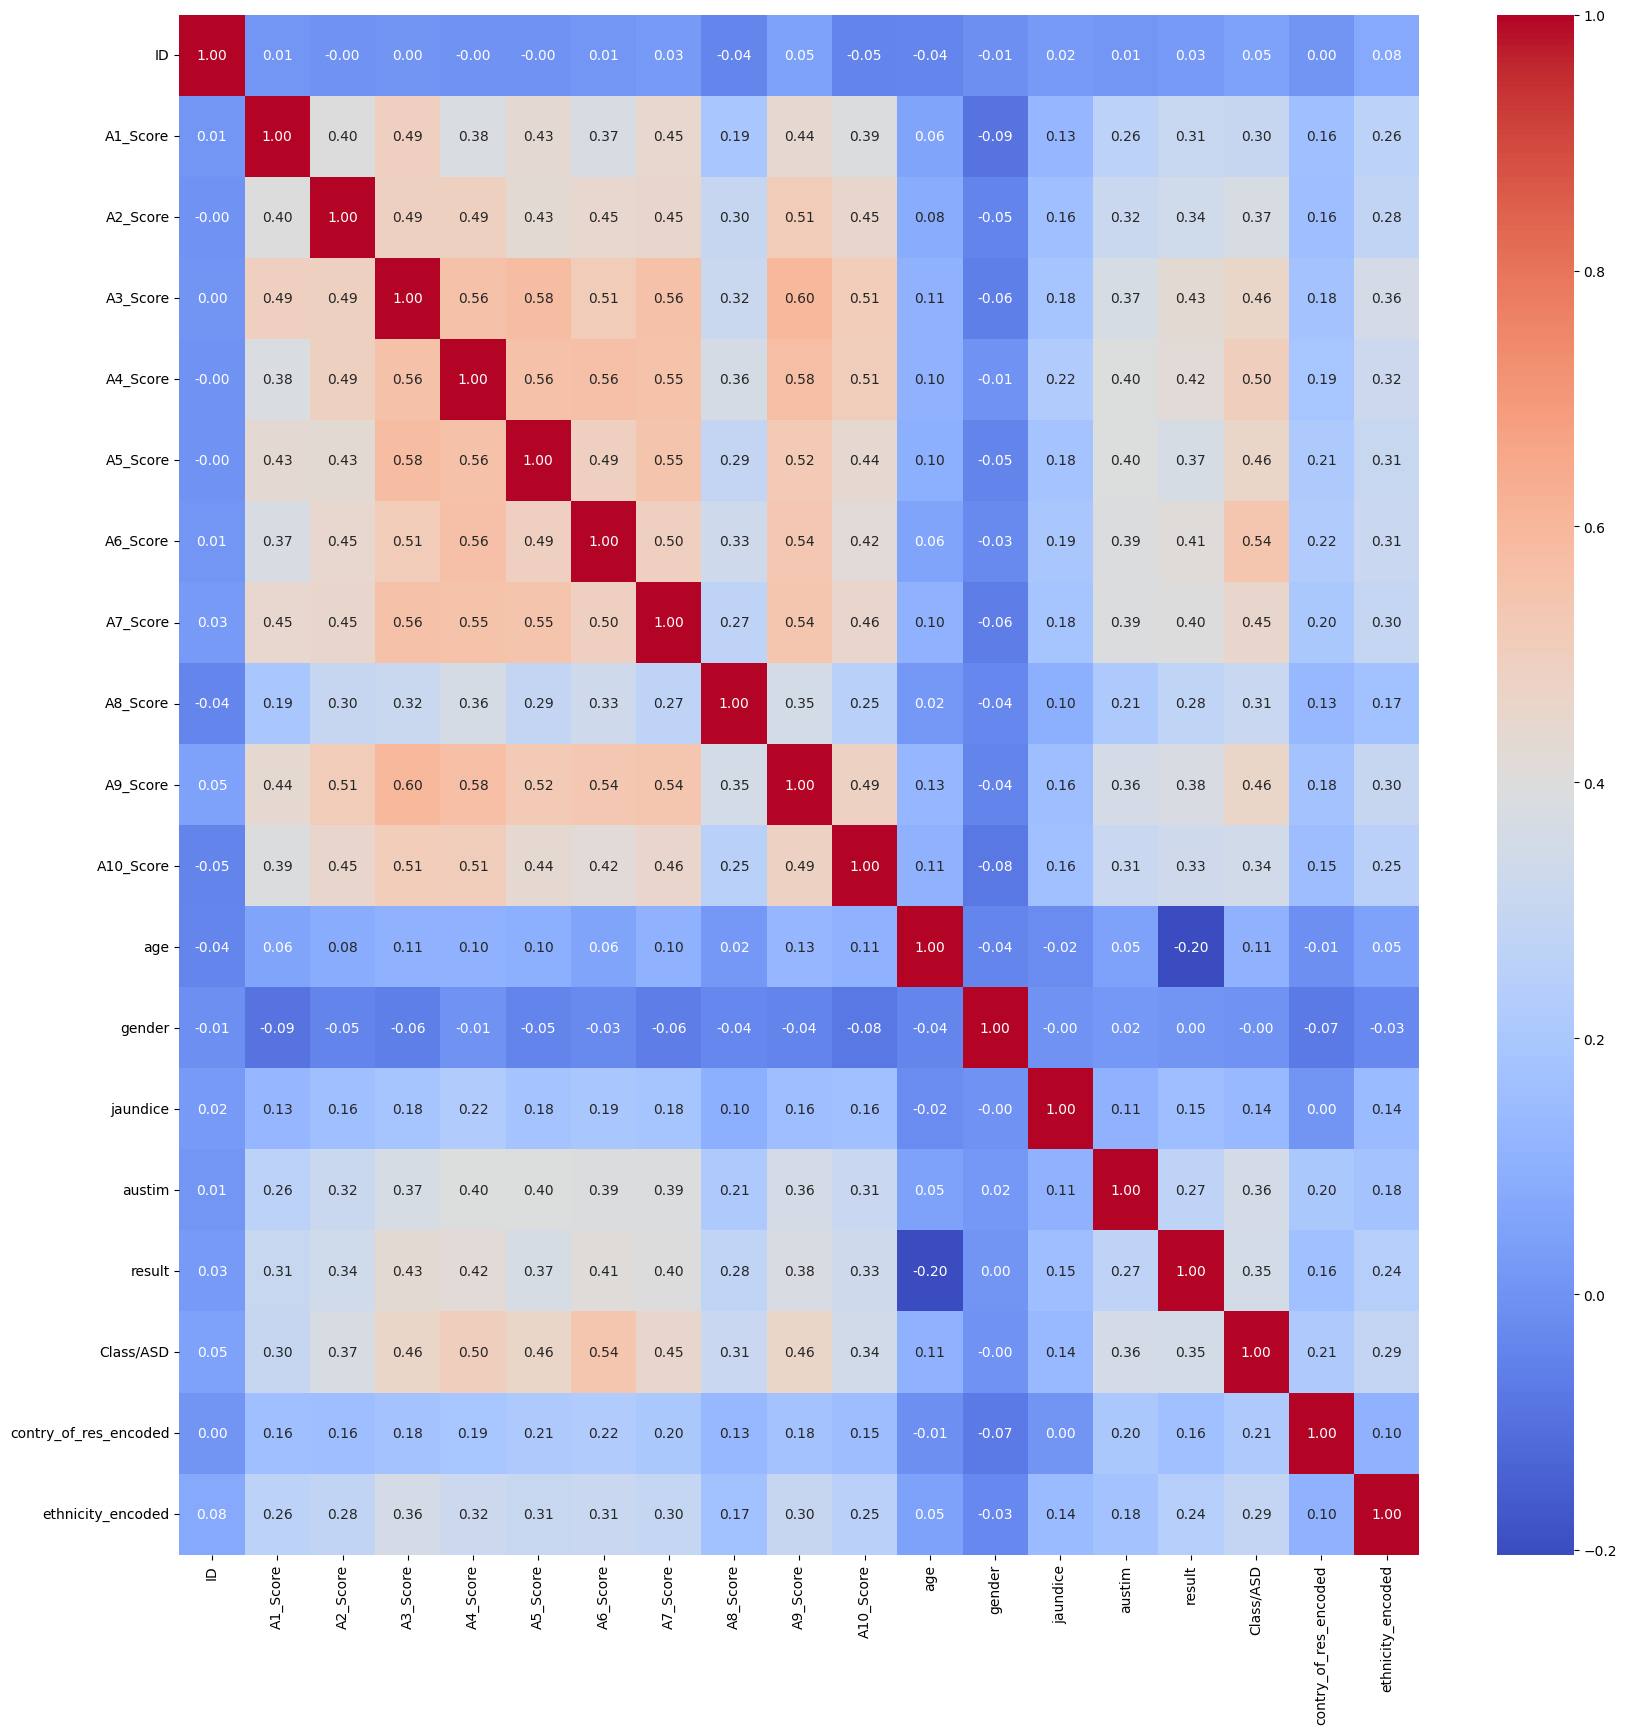

In [16]:
plt.figure(figsize = (20, 20))
sns.heatmap(df.corr(numeric_only= True), annot= True, cmap = 'coolwarm', fmt = '.2f')

In [17]:
df.corr(numeric_only= True)['Class/ASD'].sort_values(ascending= False)

# Autism in this context refer to a family member or an history of austism
# Result column, upon checking might be the result of a previous model created [might need to drop this column since it does not teall anything]
# all A_ score have strong positive correlation with the target
# age has a moderate negative correlation
# the rest are weak but can still be included

Class/ASD                1.000000
A6_Score                 0.543010
A4_Score                 0.501046
A9_Score                 0.463347
A5_Score                 0.461773
A3_Score                 0.460927
A7_Score                 0.452338
A2_Score                 0.372740
austim                   0.359217
result                   0.351906
A10_Score                0.343736
A8_Score                 0.312388
A1_Score                 0.300474
ethnicity_encoded        0.292746
contry_of_res_encoded    0.213581
jaundice                 0.138784
age                      0.109859
ID                       0.047149
gender                  -0.004368
Name: Class/ASD, dtype: float64

In [18]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,result,Class/ASD,contry_of_res_encoded,ethnicity_encoded
0,1,1,0,1,0,1,0,1,0,1,...,38.172746,0,Middle Eastern,0,0,Austria,6.351166,0,7,4
1,2,0,0,0,0,0,0,0,0,0,...,47.750517,1,Middle Eastern,0,0,India,2.255185,0,25,4
2,3,1,1,1,1,1,1,1,1,1,...,7.380373,1,White-European,0,1,United States,14.851484,1,54,9
3,4,0,0,0,0,0,0,0,0,0,...,23.561927,0,White-European,0,0,United States,2.276617,0,54,9
4,5,0,0,0,0,0,0,0,0,0,...,43.205790,1,Middle Eastern,0,0,South Africa,-4.777286,0,46,4


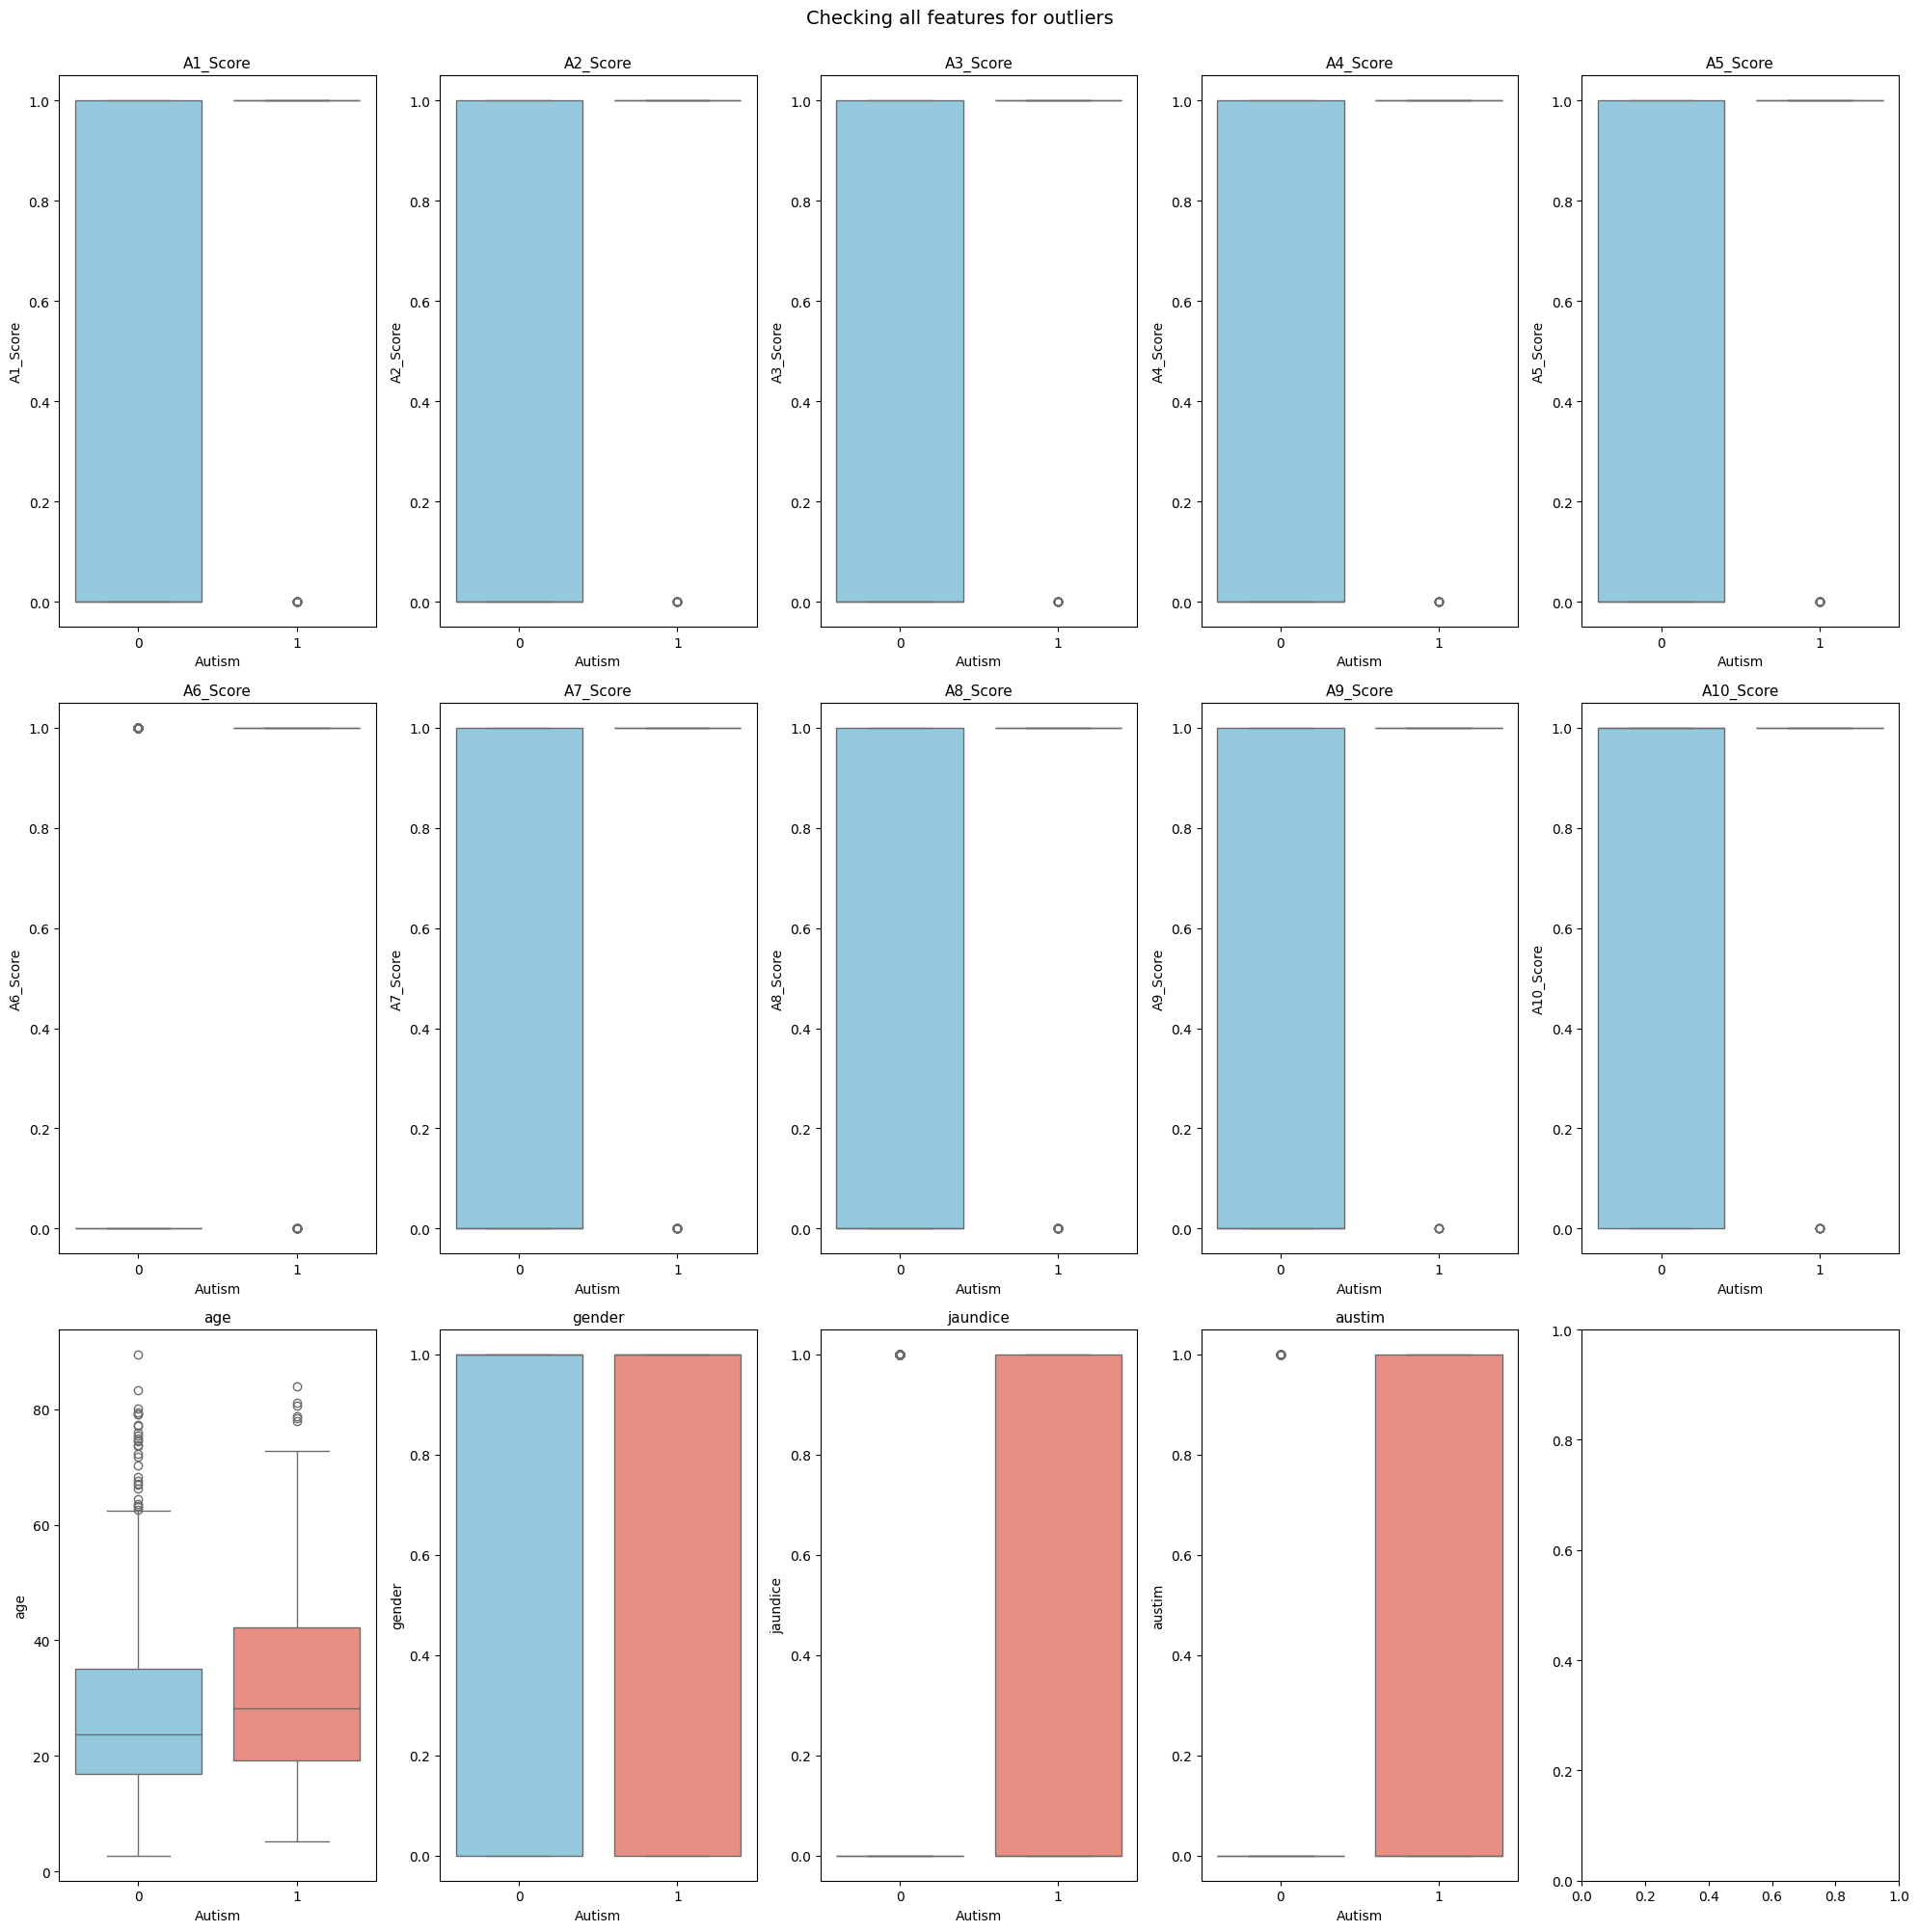

In [19]:
target_cols = list(df.drop(columns = ['Class/ASD', 'ID', 'result', 'ethnicity', 'contry_of_res', 'contry_of_res_encoded', 'ethnicity_encoded']))

fig, axes = plt.subplots(3, 5, figsize = (20, 20))
axes = axes.flatten()

for idx, feature in enumerate(target_cols):
    row = idx//2
    col = idx % 2

    sns.boxplot(
        data = df,
        x = 'Class/ASD',
        y = feature,
        hue = 'Class/ASD',
        ax = axes[idx],
        palette= ['skyblue', 'salmon'],
        legend = False
    )

    axes[idx].set_title(f'{feature}', fontsize = 11)
    axes[idx].set_xlabel('Autism')
    axes[idx].set_ylabel(feature)

plt.suptitle('Checking all features for outliers', fontsize = 14, y= 1.00)
plt.tight_layout()
plt.show()

In [20]:
# Age seems to have outliers in the 60-80 age range, which make sense since majority of the screening focuses more on children 
print(df['age'].describe())

count    800.000000
mean      28.452118
std       16.310966
min        2.718550
25%       17.198153
50%       24.848350
75%       35.865429
max       89.461718
Name: age, dtype: float64


In [21]:
X = df.drop(columns = ['Class/ASD', 'ID', 'result', 'ethnicity', 'contry_of_res', 'austim'])
y = df['Class/ASD']

In [22]:
X.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'jaundice', 'contry_of_res_encoded', 'ethnicity_encoded'],
      dtype='object')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 2, stratify= y)

In [24]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
models = {
    'LogisticRegression' :{
        'model': LogisticRegression(random_state= 2),
        'params':{
            'C':[0.001, 0.01, 0.1, 1, 10, 100],
            'penalty':['l1', 'l2', ],
            'solver': ['liblinear', 'saga'],
            'class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 4}],
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state= 2),
        'params':{
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'min_samples_split': [10, 20],
            'min_samples_leaf': [5, 10],
            'class_weight': ['balanced', 'balanced_subsample']
        }
    },
    'SVC':{
        'model': SVC(random_state= 2),
        'params':{
            'C':[0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'class_weight': ['balanced']
        }
    },
    'XGBoost':{
        'model': XGBClassifier(random_state = 2),
        'params':{
            'max_depth':[2, 3],
            'learning_rate': [0.01, 0.05],
            'min_child_weight':[5, 10],
            'subsample': [0.6, 0.7],
            'n_estimators': [100, 200],
            'reg_alpha': [0.1, 1],
            'reg_lambda': [1, 2]
        }
    },
    'LightBGM':{
        'model': LGBMClassifier(random_state= 2),
        'params':{
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth':[3, 5, 7],
            'num_leaves': [31, 50],
            'min_child_samples': [20, 30],
            'subsample' : [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'class_weight': ['balanced']
        }
    },
    'CatBoost':{
        'model': CatBoostClassifier(random_state = 2, verbose = 0),
        'params':{
            'iterations': [200, 300],
            'learning_rate':[0.01, 0.05],
            'depth': [4, 6],
            'l2_leaf_reg': [3, 5, 10],
            'border_count': [32, 64],
            'auto_class_weights': ['Balanced'],
            'early_stopping_rounds': [50]
        }
    }
}

In [26]:
results = {}
all_models = {}

for name, config in models.items():
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv = 5,
        n_jobs = -1,
        scoring = 'f1',
        verbose = 1
    )

    grid_search.fit(X_train_scaled, y_train)
    all_models[name] = grid_search.best_estimator_

    train_pred = grid_search.best_estimator_.predict(X_train_scaled)
    test_pred = grid_search.best_estimator_.predict(X_test_scaled)

    results[name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Test Accuracy': accuracy_score(y_test, test_pred),
        'Train F1': f1_score(y_train, train_pred),
        'Test F1': f1_score(y_test, test_pred),
        'Precision': precision_score(y_test, test_pred),
        'Recall' : recall_score(y_test, test_pred)
    }

best_model_name = max(results.keys(), key = lambda x: results[x]['Test F1'])
best_model = results[best_model_name]['best_model']

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[LightGBM] [Info] Number of positive: 129, number of negative: 511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\jaraneses\OneDrive - 2X LLC\Codes\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jaraneses\OneDrive - 2X LLC\Codes\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [27]:
summary_data = []

for name, result in results.items():
    summary_data.append({
        'Model': name,
        'Train F1': result['Train F1'],
        'Test F1': result['Test F1'],
        'Overfit Gap': result['Train F1'] - result['Test F1'],
        'Precision': result['Precision'],
        'Recall': result['Recall']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Test F1', ascending = False)
summary_df = summary_df.round(4)
display(summary_df)

,Model,Train F1,Test F1,Overfit Gap,Precision,Recall
5,CatBoost,0.8658,0.6316,0.2342,0.5455,0.7500
0,LogisticRegression,0.6938,0.6173,0.0765,0.5102,0.7812
1,Random Forest,0.7692,0.6154,0.1538,0.5217,0.7500
2,SVC,0.7359,0.6047,0.1313,0.4815,0.8125
4,LightBGM,0.7850,0.6000,0.1850,0.5000,0.7500
3,XGBoost,0.7717,0.5938,0.1779,0.5938,0.5938


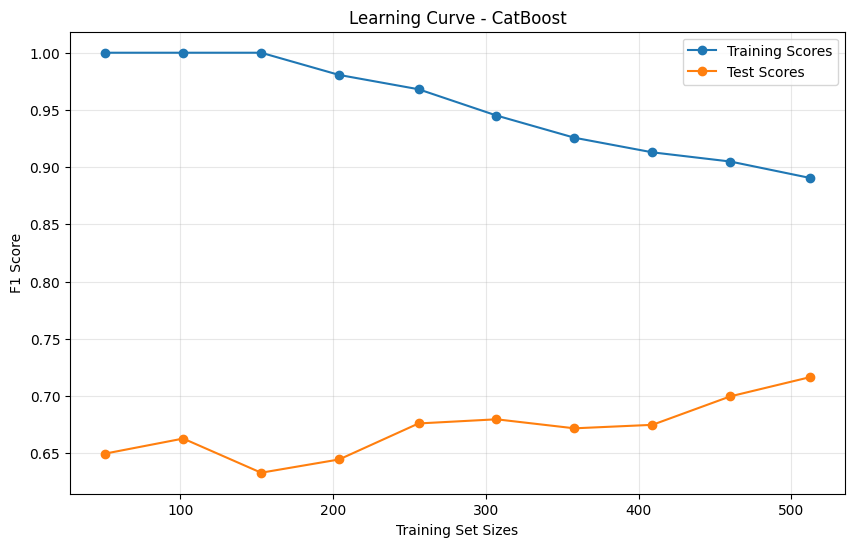

In [28]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_train, y_train,
    cv =5,
    scoring = 'f1',
    train_sizes = np.linspace(0.1, 1.0, 10),
    n_jobs = -1
)

plt.figure(figsize = (10, 6))
plt.plot(train_sizes, train_scores.mean(axis = 1), label = 'Training Scores', marker = 'o')
plt.plot(train_sizes, test_scores.mean(axis= 1), label = 'Test Scores', marker = 'o')
plt.xlabel('Training Set Sizes')
plt.ylabel('F1 Score')
plt.title(f'Learning Curve - {best_model_name}')
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

In [29]:
cv_scores = cross_val_score(
    best_model,
    X_train_scaled, y_train,
    cv = 5,
    scoring = 'f1'
)

print(f'CV F1 Scores: {cv_scores}')
print(f'Mean: {cv_scores.mean():.3f}')
print(f'Std: {cv_scores.std():.3f}')

CV F1 Scores: [0.78571429 0.6984127  0.76666667 0.60714286 0.72413793]
Mean: 0.716
Std: 0.063


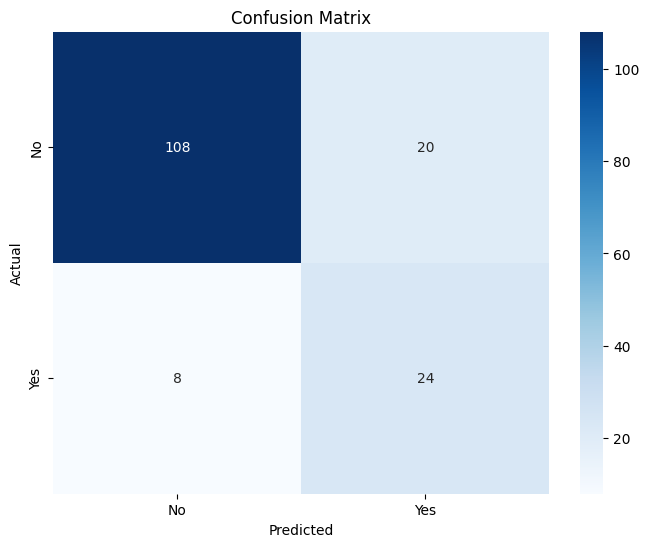

In [30]:
y_pred = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels= ['No', 'Yes'],
            yticklabels= ['No', 'Yes'])

plt.xlabel('Predicted')
plt.ylabel('Actual'),
plt.title('Confusion Matrix')
plt.show()